In [1]:
import math
import random
from dataclasses import dataclass, field, asdict
from typing import List, Dict, Any, Optional, Tuple, Callable, Literal
import os
import re
from pydantic import BaseModel
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from datasets import load_dataset
from tqdm import tqdm
from datasets import concatenate_datasets
import json
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [2]:
# Connect google drive
from google.colab import drive
drive.mount('/content/drive')
BELLO_root = '/content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7920/Final Project'

root_folder = BELLO_root

Mounted at /content/drive


In [3]:
# Login into hugging face and remove progress bars
import os
from huggingface_hub import login

# Load optional tokens from environment variables instead of hardcoding secrets.
tinker_key = os.getenv("TINKER_API_KEY")
if tinker_key:
    os.environ["TINKER_API_KEY"] = tinker_key

hf_token = os.getenv("HUGGINGFACEHUB_API_TOKEN") or os.getenv("HUGGING_FACE_HUB_TOKEN")
if hf_token:
    login(hf_token)
else:
    print("Hugging Face token not set; skipping login")

from huggingface_hub.utils import disable_progress_bars
disable_progress_bars()

from datasets.utils.logging import disable_progress_bar
disable_progress_bar()


In [4]:
# Set seed for reproducability
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [5]:
def get_directory_name(model, prompt_len, dataset, reward_type, algo):
  clean_model_name = get_clean_model_name(model)
  directory_name = f"{dataset}_{reward_type}_{algo}_{clean_model_name}_{prompt_len}_prompts"
  return directory_name

def get_clean_model_name(model):
  """
  Convert:
      meta-llama/Llama-3.2-1B
  into:
      Llama_3_2_1B_25
  """
  if "/" in model:
    base = model.rsplit("/", 1)[1]
  else:
    base = model

  if "-" in base:
    model_name, model_size = base.split("-", 1)
    model_size_clean = re.sub(r"[^0-9A-Za-z]+", "_", model_size)
    return f"{model_name}_{model_size_clean}"
  else:
    # e.g., "distilgpt2"
    return re.sub(r"[^0-9A-Za-z]+", "_", base)

def get_directory_path(model, prompt_length, dataset, reward_type, algo):
  directory_name = get_directory_name(model, prompt_length, dataset, reward_type, algo)
  save_dir = os.path.join(root_folder, "Models", directory_name)
  return save_dir

### Create PromptMLP and PromptPolicy

In [ ]:
class PromptMLP(nn.Module):
  def __init__(self, hidden_size: int, mlp_dim: int):
    super().__init__()
    self.fc1 = nn.Linear(hidden_size, mlp_dim)
    self.fc2 = nn.Linear(mlp_dim, hidden_size)

  def forward(self, h):
    # h: [..., hidden_size]
    return self.fc2(F.relu(self.fc1(h)))

In [ ]:
class PromptPolicy(nn.Module):
  def __init__(self, model_name: str, mlp_dim, device: str = "cuda"):
    super().__init__()
    self.device = device
    self.model_name = model_name
    self.lm = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    if self.tokenizer.pad_token is None:
        self.tokenizer.pad_token = self.tokenizer.eos_token

    # Freeze LM
    for p in self.lm.parameters():
        p.requires_grad = False

    hidden_size = self.lm.config.hidden_size
    # RLPrompt-style: hidden_size -> 2048 -> hidden_size
    self.mlp = PromptMLP(hidden_size, mlp_dim).to(device)

    # Fixed textual prefix used for prompt generation
    # You can tweak this to " Reasoning:", "Let's reason step by step.", etc.
    prefix_text = "Reasoning"
    self.prefix_ids = self.tokenizer.encode(
        prefix_text, add_special_tokens=False
    )

  def _base_forward_hidden(self, input_ids, attention_mask):
    """
    Run the transformer stack only, return last hidden state.
    Handles LLaMA-style naming.
    """
    with torch.no_grad():
      if hasattr(self.lm, "model"):
          # LLaMA-style (e.g., LlamaForCausalLM)
          outputs = self.lm.model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              output_hidden_states=False,
          )
      elif hasattr(self.lm, "transformer"):
          # GPT2-style (e.g., GPT2LMHeadModel / DistilGPT2)
          outputs = self.lm.transformer(
              input_ids=input_ids,
              attention_mask=attention_mask,
          )
      else:
        raise ValueError("invalid lm")

    hidden_states = outputs.last_hidden_state
    return hidden_states

  @torch.no_grad()
  def prompt_step_logits(self, prompt_ids: torch.Tensor) -> torch.Tensor:
    """
    Given current learned prompt_ids [B, T_prompt], return logits over vocab
    for the *next* prompt token.

    Context for the LM is:
      <s> + "Reasoning" + prompt_ids
    """
    bsz = prompt_ids.size(0)
    device = self.device

    bos_id = self.tokenizer.bos_token_id or self.tokenizer.eos_token_id

    # Build fixed prefix: BOS + "Reasoning"
    prefix = [bos_id] + self.prefix_ids
    prefix = torch.tensor(prefix, dtype=torch.long, device=device).unsqueeze(0)  # [1, L_prefix]
    prefix = prefix.expand(bsz, -1)  # [B, L_prefix]

    if prompt_ids.size(1) == 0:
        input_ids = prefix  # [B, L_prefix]
    else:
        input_ids = torch.cat([prefix, prompt_ids], dim=1)  # [B, L_prefix + T_prompt]

    attention_mask = torch.ones_like(input_ids, dtype=torch.long, device=device)

    hidden = self._base_forward_hidden(input_ids, attention_mask)  # [B, L, H]
    last_hidden = hidden[:, -1, :]  # [B, H]

    adapted = self.mlp(last_hidden)   # [B, vocab_size]
    logits = self.lm.lm_head(adapted)
    return logits

  def get_step_logits(self, prompt_ids: torch.Tensor) -> torch.Tensor:
    """
    Given a batch of prompt_ids [B, T], return per-token Q-values over vocab:
        Q(s_t, ·) ~ logits over vocab for each position t.

    We:
      - run the frozen LM's transformer to get hidden states
      - pass hidden states through the prompt MLP
      - project to vocab with lm_head
    """
    device = self.device
    prompt_ids = prompt_ids.to(device)
    B = prompt_ids.size(0)

    bos_id = self.tokenizer.bos_token_id or self.tokenizer.eos_token_id
    prefix = torch.tensor([bos_id] + self.prefix_ids, device=device).unsqueeze(0).expand(B, -1)
    input_ids = torch.cat([prefix, prompt_ids], dim=1)              # [B, prefix_len + T]
    attention_mask = torch.ones_like(input_ids, dtype=torch.long)   # same length as input

    hidden = self._base_forward_hidden(input_ids, attention_mask)   # [B, prefix_len + T, H]
    adapted = self.mlp(hidden)
    logits_full = self.lm.lm_head(adapted)                          # [B, prefix_len + T, V]

    prefix_len = prefix.size(1)
    return logits_full[:, prefix_len:, :]  # [B, T, V] align with prompt_ids

  @torch.no_grad()
  def greedy_generate_prompt(self, max_len: int, batch_size: int = 1, start_token: Optional[int] = None):
    """
    Used at the end to extract the final discrete prompt: greedy per step.
    """
    if start_token is None:
        start_token = self.tokenizer.bos_token_id or self.tokenizer.eos_token_id

    prompt_ids = torch.full((batch_size, 1), start_token, dtype=torch.long, device=self.device)
    for _ in range(max_len - 1):
        logits = self.prompt_step_logits(prompt_ids)
        next_token = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)
        prompt_ids = torch.cat([prompt_ids, next_token], dim=1)
    return prompt_ids

  def sample_prompt(
    self,
    max_len: int,
    batch_size: int,
    top_k: int,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Sample a learned prompt of length `max_len` using top-k sampling.
    DOES NOT include BOS/EOS in `prompt_ids`.

    Returns:
      prompt_ids: LongTensor [B, T]
      traj_logprob: FloatTensor [B]  (sum log p(a_t | a_<t))
    """
    device = self.device

    # Start with an *empty* history: no fixed BOS in the learned prompt.
    prompt_ids = torch.empty(batch_size, 0, dtype=torch.long, device=device)
    log_probs = []

    for _ in range(max_len):
        logits = self.prompt_step_logits(prompt_ids)  # [B, vocab]

        if top_k is not None and top_k > 0:
            topk_vals, topk_idx = torch.topk(logits, top_k, dim=-1)  # [B, K]
            probs = F.softmax(topk_vals, dim=-1)                     # [B, K]
            next_idx = torch.multinomial(probs, num_samples=1)       # [B, 1]
            next_token = topk_idx.gather(-1, next_idx)              # [B, 1] token ids
            chosen_logprob = torch.log(
                probs.gather(-1, next_idx) + 1e-12
            ).squeeze(-1)                                           # [B]
        else:
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)    # [B, 1]
            chosen_logprob = torch.log(
                probs.gather(-1, next_token) + 1e-12
            ).squeeze(-1)                                           # [B]

        prompt_ids = torch.cat([prompt_ids, next_token], dim=1)     # grow history
        log_probs.append(chosen_logprob)

    traj_logprob = torch.stack(log_probs, dim=-1).sum(dim=-1)       # [B]
    return prompt_ids, traj_logprob

  def save_model(self, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(self.mlp.state_dict(), os.path.join(save_dir, "prompt_mlp.pt"))

### Training / validation datasets

In [ ]:
import random
from typing import Literal
from datasets import concatenate_datasets

def get_sampled_dataset_for(
    ds,
    dataset_name: Literal["boolq", "gsm8k"],
    n_per_type: int = 16,
):
    if dataset_name == "boolq":
      label_col = "answer"   # typically True/False
      labels = ds[label_col]                   # list of labels for all rows
      unique_labels = list(set(labels))        # infer classes from data

      subsets = []
      for cv in unique_labels:
          # indices of this class
          class_indices = [i for i, lab in enumerate(labels) if lab == cv]
          available = len(class_indices)

          if available == 0:
              # Should basically never happen now, but just in case:
              raise ValueError(f"No examples with class {cv!r} in {dataset_name}")

          k = min(n_per_type, available)
          sampled_indices = random.sample(class_indices, k)
          subsets.append(ds.select(sampled_indices))

      sampled_dataset = concatenate_datasets(subsets)
      return sampled_dataset

    elif dataset_name == "gsm8k":
      full_size = len(ds)
      sample_size = min(n_per_type, full_size)
      idx = random.sample(range(full_size), sample_size)
      sampled_dataset = ds.select(idx)
      return sampled_dataset

    else:
      raise ValueError(f"Unknown dataset_name: {dataset_name}")

In [ ]:
def build_gsm8k_prompt_raw(question: str) -> str:
    return f"Question: {question}\n"

def preprocess_gsm8k_ll(dataset):
    base_prompts = []
    targets      = []

    for ex in dataset:
        question = ex["question"]
        answer   = ex["answer"]   # full CoT solution
        prompt   = build_gsm8k_prompt_raw(question)

        base_prompts.append(prompt)
        targets.append(answer)

    return {
        "base_prompts_ll": base_prompts,
        "targets_ll":      targets,
    }

def extract_final_number(solution: str) -> str | None:
    """
    Extract the final integer number from a GSM8K solution string.

    Example:
      "We get 12 + 30 = 42, so the answer is 42."
      -> "42"
    """
    nums = re.findall(r"-?\d+", solution)
    return nums[-1] if nums else None


def generate_negative_answers(correct_answer: str, k: int = 4) -> list[str]:
    """
    Generate k numeric distractors near the correct integer answer.

    Strategy:
      - Parse correct_answer as int
      - Sample offsets in [-5, 5] \ {0}
      - Return up to k distinct nearby integers as strings
    """
    try:
        ans = int(correct_answer)
    except ValueError:
        # Fallback: simple fixed distractors
        return ["0", "1", "2", "3"][:k]

    offsets = list(range(-5, 6))
    offsets.remove(0)            # don't include exact answer
    random.shuffle(offsets)

    negatives = []
    for off in offsets:
        neg = str(ans + off)
        if neg != correct_answer:
            negatives.append(neg)
        if len(negatives) == k:
            break
    return negatives

def preprocess_gsm8k_gap(dataset, k_neg):
    base_prompts = []
    final_answers = []
    negatives = []  # list[list[str]]

    for ex in dataset:
        question = ex["question"]
        solution = ex["answer"]
        prompt   = build_gsm8k_prompt_raw(question)

        correct = extract_final_number(solution)
        if correct is None:
            # you can either skip or keep a dummy; here we keep and handle later
            base_prompts.append(prompt)
            final_answers.append(None)
            negatives.append([])
            continue

        base_prompts.append(prompt)
        final_answers.append(correct)
        negatives.append(generate_negative_answers(correct, k=k_neg))

    return {
        "base_prompts_gap": base_prompts,
        "final_answers":    final_answers,
        "negatives":        negatives,
        "k_neg":            k_neg,
    }

<>:39: SyntaxWarning: invalid escape sequence '\ '
<>:39: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-3255762226.py:39: SyntaxWarning: invalid escape sequence '\ '
  - Sample offsets in [-5, 5] \ {0}


In [ ]:
def build_boolq_prompt_raw(passage: str, question: str) -> str:
    return f"{passage}\nQuestion: {question}\nAnswer:"

def preprocess_boolq(dataset):
    """
    dataset: HF Dataset or list of raw BoolQ examples.
    Returns a dict of cached strings for LL and GAP.
    """
    base_prompts_ll = []
    targets_ll      = []

    base_prompts_gap = []
    targets_yes      = []
    targets_no       = []
    answers_bool     = []   # True/False labels

    for ex in dataset:
        # LL: use "\n" if that's what your old code used
        base_ll = build_boolq_prompt_raw(ex["passage"], ex["question"]) + "\n"
        base_prompts_ll.append(base_ll)
        targets_ll.append("yes" if ex["answer"] else "no")

        # GAP: often we like a trailing space
        base_gap = build_boolq_prompt_raw(ex["passage"], ex["question"]) + " "
        base_prompts_gap.append(base_gap)
        targets_yes.append("yes")
        targets_no.append("no")
        answers_bool.append(bool(ex["answer"]))

    return {
        "base_prompts_ll":  base_prompts_ll,
        "targets_ll":       targets_ll,
        "base_prompts_gap": base_prompts_gap,
        "targets_yes":      targets_yes,
        "targets_no":       targets_no,
        "answers_bool":     answers_bool,
    }

### Reward Functions (Gap, Negative Log-likelihood)

In [ ]:
def compute_loglikelihood_batch(policy, base_prompts, targets, prompt_ids):
    """
    Batched log-likelihood for one learned prompt across a batch of examples.

    Input sequence per example:
        BOS + fixed prefix ("Reasoning") + learned prompt + base_prompt + target
    Only the target tokens are scored; everything before target is masked out.
    Returns a tensor of shape [B] with mean per-target-token log-prob.
    """
    tokenizer = policy.tokenizer
    device = policy.device

    # Prefix must match the sampling context (BOS + "Reasoning").
    bos_id = tokenizer.bos_token_id or tokenizer.eos_token_id
    prefix_ids = [bos_id] + policy.prefix_ids
    pid = prompt_ids.tolist() if prompt_ids is not None else []

    input_ids_list, labels_list = [], []
    for base_prompt, target in zip(base_prompts, targets):
        # Encode static parts
        base_ids   = tokenizer.encode(base_prompt, add_special_tokens=False)
        target_ids = tokenizer.encode(target, add_special_tokens=False)

        # Full sequence for this example
        ids = prefix_ids + pid + base_ids + target_ids

        # Mask everything except the target tokens (HF ignores -100 positions)
        labels = [-100] * (len(ids) - len(target_ids)) + target_ids

        input_ids_list.append(ids)
        labels_list.append(labels)

    # Pad to batch max length
    pad_id = tokenizer.pad_token_id or tokenizer.eos_token_id
    max_len = max(len(x) for x in input_ids_list)
    B = len(input_ids_list)

    input_ids = torch.full((B, max_len), pad_id, dtype=torch.long)
    labels    = torch.full((B, max_len), -100, dtype=torch.long)
    for i in range(B):
        L = len(input_ids_list[i])
        input_ids[i, :L] = torch.tensor(input_ids_list[i], dtype=torch.long)
        labels[i, :L]    = torch.tensor(labels_list[i],    dtype=torch.long)

    input_ids = input_ids.to(device)
    labels    = labels.to(device)

    with torch.no_grad():
        # Forward pass; we ignore the built-in loss and compute per-example LL
        logits = policy.lm(input_ids=input_ids, labels=labels).logits  # [B, L, V]

        # Convert to log-probabilities over vocab
        log_probs = F.log_softmax(logits, dim=-1)  # [B, L, V]

        # Mask selects only target positions (labels != -100)
        target_mask = (labels != -100)  # [B, L]

        # Gather log-probs of the true target tokens; dummy index for masked positions
        vocab_indices = labels.clone()
        vocab_indices[~target_mask] = 0
        token_log_probs = log_probs.gather(-1, vocab_indices.unsqueeze(-1)).squeeze(-1)  # [B, L]

        # Zero out non-target positions
        token_log_probs = token_log_probs * target_mask

        # Mean log-prob per target token for each example
        lengths = target_mask.sum(dim=-1).clamp_min(1)  # avoid divide-by-zero
        loglik = token_log_probs.sum(dim=-1) / lengths  # [B]

    return loglik  # [B]

In [ ]:
def get_train_reward_fn_for(
    dataset: Literal["boolq", "gsm8k"],
    reward_type: str,
) -> Callable[[PromptPolicy, Dict[str, Any]], float]:
    if dataset == "boolq":
        return boolq_ll_reward_fn if reward_type == "ll" else boolq_gap_reward_fn
    elif dataset == "gsm8k":
        return gsm8k_ll_reward_fn if reward_type == "ll" else gsm8k_gap_reward_fn
    raise ValueError("Unknown dataset")

In [ ]:
def get_val_reward_fn_for(dataset: Literal["boolq","gsm8k"], reward_type: str):
    if dataset == "boolq":
        return boolq_val_ll_reward_fn if reward_type == "ll" else boolq_val_gap_reward_fn
    elif dataset == "gsm8k":
        return gsm8k_val_ll_reward_fn if reward_type == "ll" else gsm8k_val_gap_reward_fn
    raise ValueError("Unknown dataset")

#### BoolQ

In [ ]:
# Log likehood reward functions for each dataset
def make_boolq_ll_reward(cache):
    base_prompts = cache["base_prompts_ll"]
    targets      = cache["targets_ll"]

    def reward_fn(policy, prompt_ids):
      """
      RLPrompt-style LL reward for a SINGLE prompt on a batch of BoolQ examples:
          r(prompt) = mean_i log p(correct_answer_i | <s> + prompt_ids + base_prompt_i)
      """
      ll = compute_loglikelihood_batch(policy, base_prompts, targets, prompt_ids)
      return ll.mean().item()
    return reward_fn

In [ ]:
lam1, lam2 = 180.0, 200.0

def make_boolq_gap_reward(cache):
    base_prompts = cache["base_prompts_gap"]
    targets_yes  = cache["targets_yes"]
    targets_no   = cache["targets_no"]
    answers_bool = cache["answers_bool"]  # list[bool]

    def reward_fn(policy, prompt_ids):
        """
        RLPrompt-style GAP reward for a SINGLE prompt on a batch of BoolQ examples:
            gap_i = p(correct) - p(incorrect)
            r(prompt) = mean_i gap_i
        """
        ll_yes = compute_loglikelihood_batch(policy, base_prompts, targets_yes, prompt_ids)
        ll_no  = compute_loglikelihood_batch(policy, base_prompts, targets_no,  prompt_ids)

        logits = torch.stack([ll_no, ll_yes], dim=-1)   # [N, 2] → {no, yes}
        probs  = torch.softmax(logits, dim=-1)
        p_no   = probs[:, 0]
        p_yes  = probs[:, 1]

        gaps = []
        for i, ans in enumerate(answers_bool):
            if ans:  # True -> "yes"
                correct   = p_yes[i]
                incorrect = p_no[i]
            else:     # False -> "no"
                correct   = p_no[i]
                incorrect = p_yes[i]
            gaps.append(correct - incorrect)

        gaps = torch.stack(gaps)
        correct = (gaps > 0).float()         # [N]

        # 4) apply λ1/λ2 scaling
        weights = lam1 * (1.0 - correct) + lam2 * correct
        reward = (weights * gaps).mean().item()
        return reward
    return reward_fn

#### G8SMK

In [ ]:
def make_gsm8k_ll_reward(cache):
    base_prompts = cache["base_prompts_ll"]
    targets      = cache["targets_ll"]

    def reward_fn(policy, prompt_ids):
      """
      LL reward on GSM8K:
          r(prompt) = mean_i log p(full_solution_i | <s> + prompt_ids + question_prompt_i)
      where full_solution_i is the whole solution string (reasoning + final answer).
      """
      ll = compute_loglikelihood_batch(policy, base_prompts, targets, prompt_ids)
      return ll.mean().item()
    return reward_fn

In [ ]:
def make_gsm8k_gap_reward(cache):
    base_prompts = cache["base_prompts_gap"]
    final_answers = cache["final_answers"]
    negatives     = cache["negatives"]
    k_neg         = cache["k_neg"]

    def reward_fn(policy, prompt_ids):
        tokenizer = policy.tokenizer
        device    = policy.device

        bos_id = tokenizer.bos_token_id or tokenizer.eos_token_id
        prefix_ids = [bos_id] + policy.prefix_ids           # align with sampling context
        pid = prompt_ids.tolist() if prompt_ids is not None else []

        input_ids_list = []
        labels_list    = []
        ex_indices     = []
        is_correct_row = []

        for i, (base_prompt, correct, negs) in enumerate(zip(base_prompts, final_answers, negatives)):
            base_ids = tokenizer.encode(base_prompt, add_special_tokens=False)

            if correct is None or not negs:
                continue

            # correct answer row
            correct_ids = tokenizer.encode(correct, add_special_tokens=False)
            ids = prefix_ids + pid + base_ids + correct_ids
            labels = [-100] * (len(ids) - len(correct_ids)) + correct_ids
            input_ids_list.append(ids)
            labels_list.append(labels)
            ex_indices.append(i)
            is_correct_row.append(True)

            # negative answers
            for neg in negs:
                neg_ids = tokenizer.encode(neg, add_special_tokens=False)
                ids = prefix_ids + pid + base_ids + neg_ids
                labels = [-100] * (len(ids) - len(neg_ids)) + neg_ids
                input_ids_list.append(ids)
                labels_list.append(labels)
                ex_indices.append(i)
                is_correct_row.append(False)

        if not input_ids_list:
            return 0.0

        pad_id = tokenizer.pad_token_id or tokenizer.eos_token_id
        max_len = max(len(x) for x in input_ids_list)
        N = len(input_ids_list)

        input_ids = torch.full((N, max_len), pad_id, dtype=torch.long)
        labels    = torch.full((N, max_len), -100, dtype=torch.long)
        for idx in range(N):
            L = len(input_ids_list[idx])
            input_ids[idx, :L] = torch.tensor(input_ids_list[idx], dtype=torch.long)
            labels[idx, :L]    = torch.tensor(labels_list[idx],    dtype=torch.long)

        input_ids = input_ids.to(device)
        labels    = labels.to(device)

        with torch.no_grad():
            logits  = policy.lm(input_ids=input_ids, labels=labels).logits  # [N, L, V]
            log_probs   = F.log_softmax(logits, dim=-1)
            target_mask = (labels != -100)

            vocab_indices = labels.clone()
            vocab_indices[~target_mask] = 0
            token_log_probs = log_probs.gather(-1, vocab_indices.unsqueeze(-1)).squeeze(-1)
            token_log_probs = token_log_probs * target_mask

            lengths = target_mask.sum(dim=-1).clamp_min(1)
            row_ll  = token_log_probs.sum(dim=-1) / lengths  # [N]

        # aggregate per-example gaps
        ex_to_correct = {}
        ex_to_negs    = {}
        for row_idx, (ex_idx, is_corr) in enumerate(zip(ex_indices, is_correct_row)):
            ll = row_ll[row_idx]
            if is_corr:
                ex_to_correct[ex_idx] = ll
            else:
                ex_to_negs.setdefault(ex_idx, []).append(ll)

        gaps = []
        for ex_idx in ex_to_correct:
            if ex_idx not in ex_to_negs or not ex_to_negs[ex_idx]:
                continue
            correct_ll = ex_to_correct[ex_idx]
            max_neg    = torch.stack(ex_to_negs[ex_idx]).max()
            gaps.append(correct_ll - max_neg)

        if not gaps:
            return 0.0

        return torch.stack(gaps).mean().item()

    return reward_fn

### Policy Training Methods (SoftQ learning, GRPO)

In [9]:
@dataclass
class ExperimentConfig:
  models: list[str] = field(default_factory=lambda: ["distilgpt2"])
  datasets: list[str] = field(default_factory=lambda: ["boolq", "gsm8k"])
  reward_type: list[str] = field(default_factory=lambda: ["gap", "ll"])
  algo: list[str] = field(default_factory=lambda: ["softq", "grpo"])

  prompt_length: list[int] = field(default_factory=lambda: [5])
  num_steps: list[int] = field(default_factory=lambda: [1_000]) #1_000
  lr: float = 5e-5
  prompt_sample_size: int = 16 # the number of prompts generated each training step
  few_shot_sample_size: int = 16 # the number of exmaples for each class for a dataset
  log_every: int = 100 #100
  top_k: int = 256
  mlp_dim: int = 2048
  k_neg: int = 4
  val_every: int = 10

  # paramters for GRPO
  clip_eps: float = 0.2
  beta_kl: float = 0.1

  # parameters to Soft Q-learning
  alpha: float = 1.0


In [ ]:
class SoftQTrainer:
  def __init__(self, policy: PromptPolicy, experimentConfig: ExperimentConfig):
    self.policy = policy
    self.exptConfig = experimentConfig
    self.opt = AdamW(self.policy.mlp.parameters(), lr=self.exptConfig.lr)

  def train_step(self, reward_fn_batched, prompt_length):
    """
    Soft Q-learning style update (RLPrompt-style, on-policy-only).

    examples: list of dicts from dataset
    reward_fn: function(policy, prompt, example) -> float
              (uses the current policy's prompt to query the task LM)
    """
    device = self.policy.device
    prompt_sample_size = self.exptConfig.prompt_sample_size

    # Hyperparameters for Soft Q
    alpha = self.exptConfig.alpha  # temperature in Q-backup

    # 1. Sample prompts from policy (on-policy)
    prompt_ids, _ = self.policy.sample_prompt(
        max_len=prompt_length,
        batch_size=prompt_sample_size,
        top_k=self.exptConfig.top_k,
    )  # prompt_ids: [B, T]

    # 2. Compute scalar rewards per prompt
    rewards = []
    for k in range(prompt_sample_size):
      r_k = reward_fn_batched(self.policy, prompt_ids[k])
      rewards.append(r_k)

    rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
    mean_r = rewards.mean()
    std_r = rewards.std() + 1e-8

    # z-score normalize rewards (RLPrompt-style reward stabilization)
    norm_rewards = (rewards - mean_r) / std_r  # [B]

    # 3. Compute Q-values from policy LM head for every step
    #    We treat logits as Q(s_t, ·). Shape: [B, T, V]
    logits_all = self.policy.get_step_logits(prompt_ids)  # requires helper on policy
    # Q(s,a) = logits (you can optionally scale or shift if you want)
    Q_all = logits_all  # [B, T, V]

    # 4. Extract Q(s_t, a_t) for the actions actually taken
    # prompt_ids: [B, T] are the chosen actions at each step
    actions = prompt_ids  # [B, T]
    Q_sa = Q_all.gather(-1, actions.unsqueeze(-1)).squeeze(-1)  # [B, T]

    # 5. Build soft Bellman targets for each time step
    # Episode is length T, reward only at the end; we use same (normalized) reward
    # R for all steps in the trajectory.
    R = norm_rewards.unsqueeze(-1)  # [B, 1] -> broadcast over T if needed

    with torch.no_grad():
      # For next-state Q(s_{t+1}, ·), we use Q_all shifted by one step
      # Q_next_all: [B, T-1, V]
      Q_next_all = Q_all[:, 1:, :]  # drop first step, no grad for target
      # Soft value at next state: V_soft(s_{t+1}) = α log ∑_a exp(Q(s_{t+1}, a) / α)
      # Shape: [B, T-1]
      V_soft_next = alpha * torch.logsumexp(Q_next_all / alpha, dim=-1)
      # Targets: for t < T-1, R + V_soft(s_{t+1}); for t = T-1, just R
      target = torch.zeros_like(Q_sa)  # [B, T]
      # For steps 0..T-2
      target[:, :-1] = R + V_soft_next
      # For last step
      target[:, -1] = R.squeeze(-1)

    # 6. Q-regression loss: (Q(s_t, a_t) - target_t)^2
    q_loss = F.mse_loss(Q_sa, target)
    loss = q_loss

    # 8. Update MLP parameters (policy network)
    self.opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.policy.mlp.parameters(), 1.0)
    self.opt.step()

    return {
        "loss": loss.item(),
        "reward_mean": mean_r.item(),
        "reward_std": std_r.item(),
        "q_loss": q_loss.item(),
    }

In [ ]:
class GRPOTrainer:
  def __init__(self, policy: PromptPolicy, exptConfig: ExperimentConfig):
      self.policy = policy
      self.exptConfig = exptConfig
      self.opt = AdamW(self.policy.mlp.parameters(), lr=exptConfig.lr)

      hidden_size = policy.lm.config.hidden_size
      device = policy.device

      # ----- Reference MLP (KL anchor; typically the SFT / initial policy) -----
      self.mlp_ref = PromptMLP(hidden_size, exptConfig.mlp_dim).to(device)
      self.mlp_ref.load_state_dict(self.policy.mlp.state_dict())
      for p in self.mlp_ref.parameters():
          p.requires_grad = False

      # ----- Old MLP (denominator in PPO ratio) -----
      # Will be refreshed at each train_step *before* collecting trajectories.
      self.mlp_old = PromptMLP(hidden_size, exptConfig.mlp_dim).to(device)
      self.mlp_old.load_state_dict(self.policy.mlp.state_dict())
      for p in self.mlp_old.parameters():
          p.requires_grad = False

      # KL coefficient (you can expose this in ExperimentConfig)
      self.beta_kl = exptConfig.beta_kl

  def _token_logprobs_from_hidden(self, hidden, prompt_ids, mlp, prefix_len):
    """
    hidden: [B, T, H] from frozen LM
    prompt_ids: [B, T]
    mlp: which head to use (current, old, or ref)
    """
    logits = self.policy.lm.lm_head(mlp(hidden))      # [B, prefix_len + T, V]

    # Drop prefix so ratios/advantages are only over the learned prompt tokens
    logits_prompt = logits[:, prefix_len:, :]         # [B, T, V]
    log_probs = F.log_softmax(logits_prompt, dim=-1)  # [B, T, V]

    # Token logprobs for the prompt (shifted by one, as usual for LM)
    logits_shift = logits_prompt[:, :-1, :]           # [B, T-1, V]
    labels = prompt_ids[:, 1:]                        # [B, T-1]
    token_logprobs = F.log_softmax(logits_shift, dim=-1)
    token_logprobs = token_logprobs.gather(-1, labels.unsqueeze(-1)).squeeze(-1)  # [B, T-1]

    return token_logprobs, log_probs                  # token_logprobs for PPO ratio, log_probs for KL

  def train_step(self, reward_fn_batched, prompt_length):
      """
      GRPO-style token-level PPO step:

      - Use mlp_old as π_old (denominator in PPO ratio).
      - Use mlp_ref as π_ref (KL anchor).
      - Collect B samples on-policy from current π.
      - Normalize rewards across the batch (batch-relative advantages).
      - Apply token-level clipping with those advantages.
      - Add explicit KL(π || π_ref) penalty.

      Assumes: batch_size == exptConfig.prompt_sample_size.
      """
      device = self.policy.device
      B = self.exptConfig.prompt_sample_size
      clip_eps = self.exptConfig.clip_eps
      beta_kl = self.beta_kl

      # 0. Snapshot "old" policy (π_old) BEFORE collecting this batch.
      #    This matches standard PPO / GRPO: data is generated by π_old,
      #    while we update π (self.policy.mlp).
      self.mlp_old.load_state_dict(self.policy.mlp.state_dict())
      for p in self.mlp_old.parameters():
          p.requires_grad = False

      # 1. Sample B prompts from the *current* policy (same weights as mlp_old at this point).
      prompt_ids, _ = self.policy.sample_prompt(
          max_len=prompt_length,
          batch_size=B,
          top_k=self.exptConfig.top_k,
      )  # [B, T]

      # 2. Compute reward per sampled prompt.
      rewards = []
      for k in range(B):
        r_k = reward_fn_batched(self.policy, prompt_ids[k])
        rewards.append(r_k)

      rewards = torch.tensor(rewards, dtype=torch.float32, device=device)  # [B]

      # 3. Batch-relative advantages (here group_size == batch_size).
      mean_r = rewards.mean()
      std_r = rewards.std() + 1e-8
      advantages_seq = (rewards - mean_r) / std_r   # [B]
      # Broadcast sequence-level advantage to all tokens.
      # This is equivalent to giving each token the same A_i in the sequence.
      # Still a token-level objective because the ratio is per token.
      # If you want length-penalization, you can re-scale by 1/T, etc.
      # but this is the GRPO-style scalar-per-trajectory setup.

      bos_id = self.policy.tokenizer.bos_token_id or self.policy.tokenizer.eos_token_id
      prefix = torch.tensor([bos_id] + self.policy.prefix_ids, device=device).unsqueeze(0).expand(B, -1)
      prefix_mask = torch.ones_like(prefix, dtype=torch.long)

      input_ids = torch.cat([prefix, prompt_ids], dim=1)              # [B, prefix_len + T]
      attention_mask = torch.cat([prefix_mask, torch.ones_like(prompt_ids)], dim=1)  # [B, prefix_len + T]
      hidden = self.policy._base_forward_hidden(input_ids, attention_mask)

      prefix_len = prefix.size(1)

      logp_new_tok, logp_new_full = self._token_logprobs_from_hidden(hidden, prompt_ids, self.policy.mlp, prefix_len)
      with torch.no_grad():
          logp_old_tok, _  = self._token_logprobs_from_hidden(hidden, prompt_ids, self.mlp_old, prefix_len)
          _, logp_ref_full = self._token_logprobs_from_hidden(hidden, prompt_ids, self.mlp_ref, prefix_len)

      B_check, Tm1 = logp_new_tok.shape
      assert B_check == B
      advantages = advantages_seq.unsqueeze(-1).expand(B, Tm1)      # [B, T-1]

      # 4. PPO ratio: r_t = exp(log π_new - log π_old)
      ratio = torch.exp(logp_new_tok - logp_old_tok)
      clipped_ratio = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps)
      pg_terms = torch.min(ratio * advantages, clipped_ratio * advantages)
      pg_loss = -pg_terms.mean()

      # 5. Explicit KL penalty: KL(π_new || π_ref), estimated token-wise.
      #    logp_new - logp_ref is the log-ratio; mean over tokens approximates KL.
      token_kl = F.kl_div(logp_new_full, logp_ref_full, log_target=True, reduction="batchmean")

      # When minimizing, we ADD beta * KL to the loss.
      loss = pg_loss + beta_kl * token_kl

      # 6. Backprop: only update the trainable MLP.
      self.opt.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.policy.mlp.parameters(), 1.0)
      self.opt.step()

      return {
          "loss": loss.item(),
          "reward_mean": mean_r.item(),
          "reward_std": std_r.item(),
          "kl": token_kl.item(),
          "adv_mean": advantages_seq.mean().item(),
      }

  # Optional: if you want to occasionally "refresh" the reference MLP
  # to the current policy (like GRPO's outer loop), call this every N steps.
  def refresh_reference(self):
      self.mlp_ref.load_state_dict(self.policy.mlp.state_dict())
      for p in self.mlp_ref.parameters():
          p.requires_grad = False


### Training

In [10]:
experimentConfig = ExperimentConfig()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Training datasets
boolq_train = get_sampled_dataset_for(load_dataset("boolq", split="train"), "boolq", experimentConfig.few_shot_sample_size)
gsm8k_train = get_sampled_dataset_for(load_dataset("gsm8k", "main", split="train"), "gsm8k", experimentConfig.few_shot_sample_size)

# Precompute caches ONCE
boolq_cache_ll  = preprocess_boolq(boolq_train)
gsm8k_cache_ll  = preprocess_gsm8k_ll(gsm8k_train)

boolq_cache_gap = boolq_cache_ll          # can reuse for GAP (we included both)
gsm8k_cache_gap = preprocess_gsm8k_gap(gsm8k_train, k_neg=experimentConfig.k_neg)

# Make reward functions (closures)
boolq_ll_reward_fn   = make_boolq_ll_reward(boolq_cache_ll)
boolq_gap_reward_fn  = make_boolq_gap_reward(boolq_cache_gap)

gsm8k_ll_reward_fn   = make_gsm8k_ll_reward(gsm8k_cache_ll)
gsm8k_gap_reward_fn  = make_gsm8k_gap_reward(gsm8k_cache_gap)

In [ ]:
# Validation datasets (same few_shot_sample_size)
boolq_valid = get_sampled_dataset_for(load_dataset("boolq", split="validation"),
                                      "boolq", experimentConfig.few_shot_sample_size)
gsm8k_valid = get_sampled_dataset_for(load_dataset("gsm8k", "main", split="train"),
                                      "gsm8k", experimentConfig.few_shot_sample_size)

# Validation caches
boolq_val_cache_ll  = preprocess_boolq(boolq_valid)
gsm8k_val_cache_ll  = preprocess_gsm8k_ll(gsm8k_valid)
boolq_val_cache_gap = boolq_val_cache_ll
gsm8k_val_cache_gap = preprocess_gsm8k_gap(gsm8k_valid, k_neg=experimentConfig.k_neg)

# Validation reward fns
boolq_val_ll_reward_fn  = make_boolq_ll_reward(boolq_val_cache_ll)
boolq_val_gap_reward_fn = make_boolq_gap_reward(boolq_val_cache_gap)
gsm8k_val_ll_reward_fn  = make_gsm8k_ll_reward(gsm8k_val_cache_ll)
gsm8k_val_gap_reward_fn = make_gsm8k_gap_reward(gsm8k_val_cache_gap)

In [ ]:
@dataclass
class TrainHistory:
    step: List[int] = field(default_factory=list)
    loss: List[float] = field(default_factory=list)
    reward_mean: List[float] = field(default_factory=list)
    reward_std: List[float] = field(default_factory=list)

    val_step: List[int] = field(default_factory=list)
    val_reward_mean: List[float] = field(default_factory=list)

    # SOFT Q Specific
    q_loss: List[float] = field(default_factory=list)
    # GRPO Specific
    kl: List[float] = field(default_factory=list)
    adv_mean: List[float] = field(default_factory=list)

    def append(self, step, stats):
      self.step.append(step)
      self.loss.append(stats["loss"])
      self.reward_mean.append(stats.get("reward_mean", 0.0))
      self.reward_std.append(stats.get("reward_std", 0.0))
      self.kl.append(stats.get("kl", 0.0))       # 0 if missing
      self.q_loss.append(stats.get("q_loss", 0.0))
      self.adv_mean.append(stats.get("adv_mean", 0.0))

    def append_val(self, step, val_reward):
      self.val_step.append(step)
      self.val_reward_mean.append(val_reward)

    def save(self, run_name):
      logs_dir = os.path.join(root_folder, "Logs")
      os.makedirs(logs_dir, exist_ok=True)
      json_path = os.path.join(logs_dir, f"{run_name}_history.json")

      d = asdict(self)
      rounded = {
          key: [round(v, 3) if isinstance(v, float) else v for v in value]
          for key, value in d.items()
      }

      with open(json_path, "w") as f:
          json.dump(rounded, f, indent=None, separators=(", ", ": "))

In [ ]:
from typing import Literal
import random

def build_trainer_for(
    algo: Literal["softq", "grpo"],
    policy: PromptPolicy,
    exptConfig: ExperimentConfig,
):
    """
    Construct either a SoftQTrainer or GRPOTrainer with the given hyperparameters.
    """
    if algo == "softq":
        trainer = SoftQTrainer(policy, exptConfig)
    elif algo == "grpo":
        trainer = GRPOTrainer(policy, exptConfig)
    else:
        raise ValueError(f"Unknown algo: {algo}")
    return trainer


def train_prompt_policy_for_steps(
    policy: PromptPolicy,
    dataset: Literal["boolq", "gsm8k"],
    reward_type: str,
    algo: Literal["softq", "grpo"],
    exptConfig: ExperimentConfig,
    num_steps: int,
    prompt_length: int,
):
  """
  Train a PromptPolicy with RL on a chosen dataset +


    reward type + algorithm.

  Args:
    policy:       PromptPolicy(model, device)
    dataset:      "boolq" or "gsm8k"
    reward_type:  boolq: {"gap","ll"}, gsm8k: {"cot_ll"}
    algo:         "softq" or "grpo"
    exptConfig:   contains hyperparameters for training
    num_steps:    number of training steps
    prompt_length: length of the prompt to use for training
  """
  history = TrainHistory()

  # 1. Build RL trainer (SoftQ or GRPO)
  trainer = build_trainer_for(
      algo=algo,
      policy=policy,
      exptConfig=exptConfig,
  )

  # 2. Select the reward function
  train_reward_fn = get_train_reward_fn_for(dataset, reward_type)
  val_reward_fn   = get_val_reward_fn_for(dataset, reward_type)

  # 3. Main RL training loop
  for step in tqdm(range(num_steps), desc=f"{dataset}_{reward_type}_{algo}"):
      stats = trainer.train_step(train_reward_fn, prompt_length)
      history.append(step+1, stats)

      if (step + 1) % exptConfig.log_every == 0:
        msg = (
            f"\n[{algo.upper()}][{dataset}][{reward_type}] "
            f"step {step+1}/{num_steps} "
            f"loss={stats['loss']:.4f} "
            f"reward_mean={stats.get('reward_mean', 0.0):.4f} "
            f"reward_std={stats.get('reward_std', 0.0):.4f}"
        )
        if "kl" in stats:
            msg += f" kl={stats['kl']:.4f}"
        print(msg)

      if (step + 1) % exptConfig.val_every == 0:
        # sample one prompt to evaluate
        val_prompt_ids, _ = policy.sample_prompt(
            max_len=prompt_length, batch_size=1, top_k=exptConfig.top_k
        )
        val_reward = val_reward_fn(policy, val_prompt_ids[0])
        history.append_val(step+1, val_reward)
        print(f"[VAL][{dataset}][{reward_type}] step {step+1}: reward={val_reward:.4f}")

  print(f"Finished training: dataset={dataset}, reward_type={reward_type}, algo={algo}")
  return history


In [ ]:
for model in experimentConfig.models:
  for prompt_length, num_steps in zip(experimentConfig.prompt_length, experimentConfig.num_steps):
    for dataset in experimentConfig.datasets:
      for algo in experimentConfig.algo:
        for reward_type in experimentConfig.reward_type:
            save_dir = get_directory_path(model, prompt_length, dataset, reward_type, algo)

            if os.path.exists(save_dir):
              print(f"[Skip] {save_dir} already exists — continuing.")
              continue

            # create the prompt policy contains frozen LLM and MLP
            promptPolicy = PromptPolicy(model, experimentConfig.mlp_dim, device)
            history = train_prompt_policy_for_steps(promptPolicy, dataset, reward_type, algo, experimentConfig, num_steps, prompt_length)

            # save history to disk for plotting
            run_name = get_directory_name(promptPolicy.model_name, prompt_length, dataset, reward_type, algo)
            history.save(run_name)

            # save the prompt policy
            promptPolicy.save_model(save_dir)
            print("Prompt policy saved to: ", save_dir)

[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7920/Final Project/Models/boolq_gap_softq_distilgpt2_5_prompts already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7920/Final Project/Models/boolq_ll_softq_distilgpt2_5_prompts already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7920/Final Project/Models/boolq_gap_grpo_distilgpt2_5_prompts already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7920/Final Project/Models/boolq_ll_grpo_distilgpt2_5_prompts already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7920/Final Project/Models/gsm8k_gap_softq_distilgpt2_5_prompts already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7920/Final Project/Models/gsm8k_ll_softq_distilgpt2_5_prompts already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7920/Final Project/Models/gsm8k_gap_grpo_distil

### Training Visualization

In [6]:
def plot_history_on_ax(ax, run_name, logs_dir, algo):
    path = os.path.join(logs_dir, f"{run_name}_history.json")
    if not os.path.exists(path):
        ax.set_title(f"[missing] {run_name}", fontsize=8)
        return

    with open(path, "r") as f:
        h = json.load(f)

    steps   = h.get("step", [])
    rewards = h.get("reward_mean", [])
    losses  = h.get("loss", [])
    advs    = h.get("adv_mean", [])

    if not steps:
        ax.set_title(f"[empty] {run_name}", fontsize=8)
        return

    # ----------------------------------------------------
    # Choose what to plot (SoftQ → reward, GRPO → advantage)
    # ----------------------------------------------------
    if algo == "grpo":
        y_vals  = advs
        y_label = "adv_mean"
    else:
        y_vals  = rewards
        y_label = "reward_mean"

    # ----------------------------------------------------
    # Plot left axis (blue)
    # ----------------------------------------------------
    line1, = ax.plot(steps, y_vals, color="tab:blue", label=y_label)
    ax.set_xlabel("step")
    ax.set_ylabel(y_label, color="tab:blue")
    ax.tick_params(axis="y", labelcolor="tab:blue")
    ax.grid(True, alpha=0.3)

    # ----------------------------------------------------
    # Plot right axis (red)
    # ----------------------------------------------------
    ax2 = ax.twinx()
    line2, = ax2.plot(steps, losses, color="tab:red", label="loss")
    ax2.set_ylabel("loss", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # ----------------------------------------------------
    # Combine legends (left + right)
    # ----------------------------------------------------
    ax.legend(handles=[line1, line2], loc="upper right", fontsize=7)

    ax.set_title(run_name, fontsize=8)

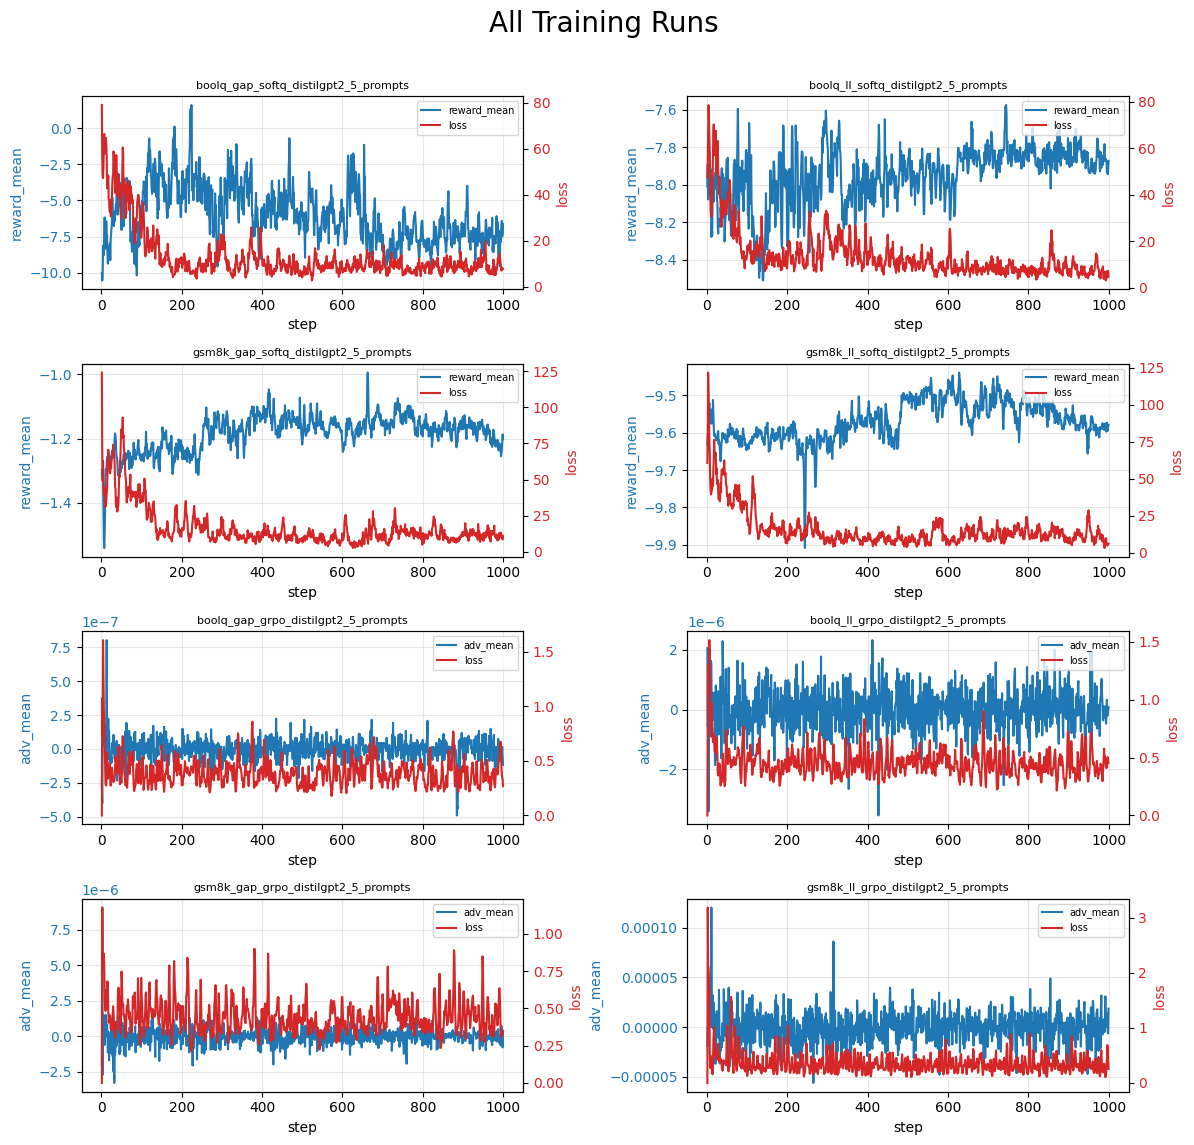

In [25]:
def plot_all_histories(experimentConfig, root_folder):
    logs_dir = os.path.join(root_folder, "Logs")

    # Collect run list
    runs = []
    for model in experimentConfig.models:
        for prompt_length, num_steps in zip(experimentConfig.prompt_length, experimentConfig.num_steps):
            for dataset in experimentConfig.datasets:
                for algo in experimentConfig.algo:
                    for reward_type in experimentConfig.reward_type:
                        run_name = get_directory_name(model, prompt_length, dataset, reward_type, algo)
                        runs.append((run_name, algo))

    if len(runs) == 0:
        print("[warn] no runs found")
        return

    # ---- SORT SO GRPO APPEARS LAST (i.e., bottom rows) ----
    runs.sort(key=lambda x: x[1] == "grpo")
    # --------------------------------------------------------

    # ---- FORCE TRUE 4×2 GRID ----
    n_rows = 4
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12), squeeze=False)
    axes = axes.flatten()

    # Fill subplots (max 8)
    for idx, (run_name, algo) in enumerate(runs[:8]):
        ax = axes[idx]
        plot_history_on_ax(ax, run_name, logs_dir, algo)

    # Hide unused axes
    for idx in range(len(runs), 8):
        axes[idx].set_visible(False)

    fig.suptitle("All Training Runs", fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])

    plt.savefig(os.path.join(logs_dir, "all_runs.png"), dpi=300)
    plt.show()

plot_all_histories(experimentConfig, root_folder)

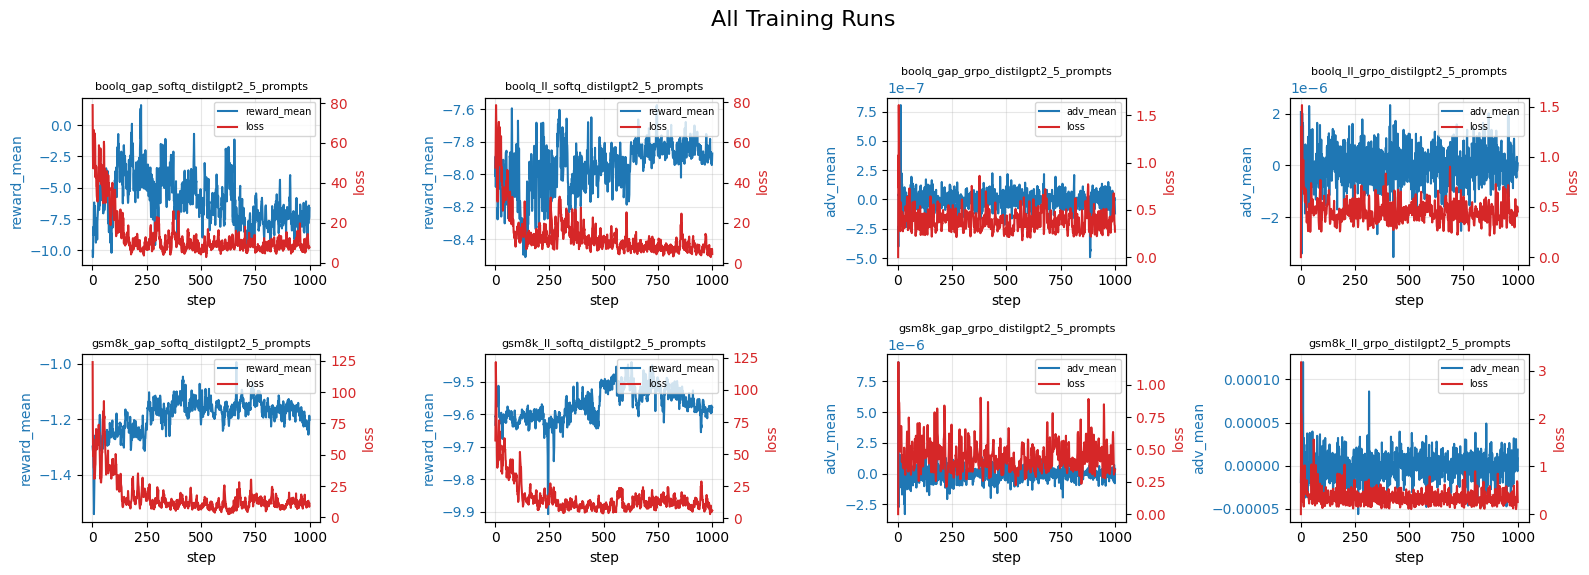

In [12]:
def plot_all_histories(experimentConfig, root_folder):
    logs_dir = os.path.join(root_folder, "Logs")

    # Collect run list
    runs = []
    for model in experimentConfig.models:
        for prompt_length, num_steps in zip(experimentConfig.prompt_length, experimentConfig.num_steps):
            for dataset in experimentConfig.datasets:
                for algo in experimentConfig.algo:
                    for reward_type in experimentConfig.reward_type:
                        run_name = get_directory_name(model, prompt_length, dataset, reward_type, algo)
                        runs.append((run_name, algo))

    n = len(runs)
    if n == 0:
        print("[warn] no runs found")
        return

    # Grid layout parameters
    n_cols = 4                       # adjust as needed (4 columns → 2 rows for 8 runs)
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 3 * n_rows),
        squeeze=False
    )

    # Fill each subplot
    for idx, (run_name, algo) in enumerate(runs):
        r = idx // n_cols
        c = idx % n_cols
        ax = axes[r][c]
        plot_history_on_ax(ax, run_name, logs_dir, algo)

    # Hide unused axes
    for idx in range(n, n_rows * n_cols):
        r = idx // n_cols
        c = idx % n_cols
        axes[r][c].set_visible(False)

    fig.suptitle("All Training Runs", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])

    # Save the giant image
    plt.savefig(os.path.join(logs_dir, "all_runs.png"), dpi=300)
    plt.show()

plot_all_histories(experimentConfig, root_folder)

### Validation Visualization

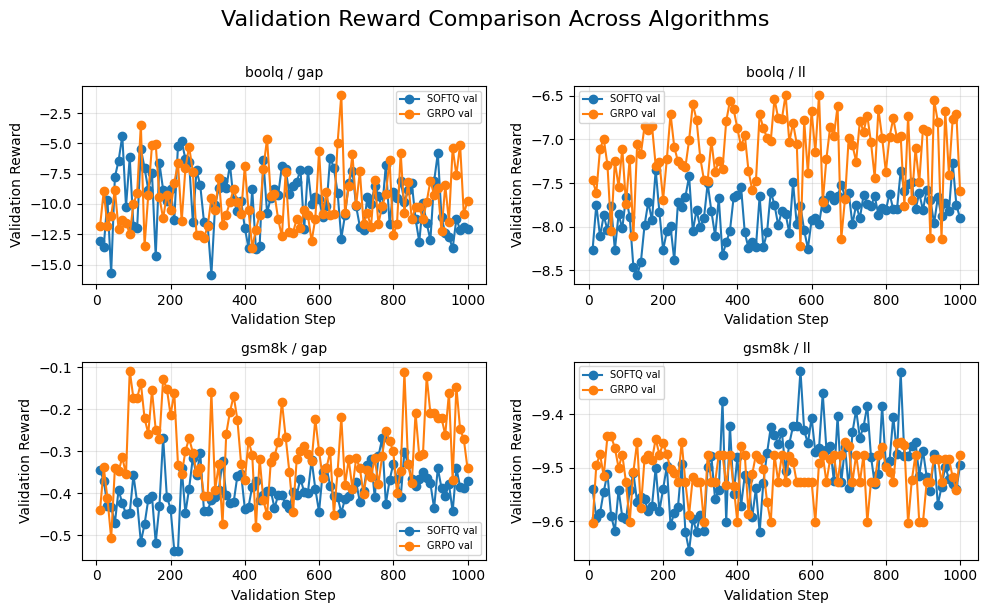

In [ ]:
def plot_val_compare_on_ax(ax, model, prompt_length, dataset, reward_type, algos, logs_dir):
    # Color map per algorithm for consistency
    algo_colors = {
        "softq": "tab:blue",
        "grpo":  "tab:orange",
    }

    plotted = False

    for algo in algos:
        run_name = get_directory_name(model, prompt_length, dataset, reward_type, algo)
        path = os.path.join(logs_dir, f"{run_name}_history.json")

        if not os.path.exists(path):
            print(f"[skip] missing {path}")
            continue

        with open(path, "r") as f:
            h = json.load(f)

        val_steps   = h.get("val_step", [])
        val_rewards = h.get("val_reward_mean", [])

        if not val_steps:
            print(f"[skip] no validation entries for {run_name}")
            continue

        # Plot each algorithm's line
        color = algo_colors.get(algo, None)
        ax.plot(
            val_steps,
            val_rewards,
            marker="o",
            label=f"{algo.upper()} val",
            color=color
        )

        plotted = True

    if not plotted:
        ax.set_visible(False)
        return

    ax.set_title(f"{dataset} / {reward_type}", fontsize=10)
    ax.set_xlabel("Validation Step")
    ax.set_ylabel("Validation Reward")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best", fontsize=7)

def plot_all_val_comparisons(experimentConfig, root_folder):
    logs_dir = os.path.join(root_folder, "Logs")

    # Collect unique dataset × reward_type combinations
    combos = []
    for dataset in experimentConfig.datasets:
        for reward_type in experimentConfig.reward_type:
            combos.append((dataset, reward_type))

    n = len(combos)
    if n == 0:
        print("[warn] no dataset/reward combos found")
        return

    n_cols = 2                         # 3 per row is nice; adjust if needed
    n_rows = 2

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(5 * n_cols, 3.2 * n_rows),
        squeeze=False
    )

    for idx, (dataset, reward_type) in enumerate(combos):
        r = idx // n_cols
        c = idx % n_cols
        ax = axes[r][c]

        for model in experimentConfig.models:
            for prompt_length, num_steps in zip(experimentConfig.prompt_length, experimentConfig.num_steps):

                # Plot both SoftQ and GRPO curves onto this axis
                plot_val_compare_on_ax(
                    ax,
                    model,
                    prompt_length,
                    dataset,
                    reward_type,
                    ["softq", "grpo"],
                    logs_dir
                )

    # Hide unused axes (if combos < n_rows*n_cols)
    for idx in range(n, n_rows * n_cols):
        r = idx // n_cols
        c = idx % n_cols
        axes[r][c].set_visible(False)

    fig.suptitle("Validation Reward Comparison Across Algorithms", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])

    # Save giant image
    plt.savefig(os.path.join(logs_dir, "all_val_comparisons.png"), dpi=300)
    plt.show()

plot_all_val_comparisons(experimentConfig, root_folder)


### Evaluation

In [ ]:
boolq_test = load_dataset("boolq", split="validation")
gsm8k_test = load_dataset("gsm8k", "main", split="test")

# boolq_test = get_sampled_dataset_for(load_dataset("boolq", split="validation"),
#                                      "boolq", experimentConfig.few_shot_sample_size)
# gsm8k_test = get_sampled_dataset_for(load_dataset("gsm8k", "main", split="test"),
#                                      "gsm8k", experimentConfig.few_shot_sample_size)

# Test caches
boolq_test_cache_ll  = preprocess_boolq(boolq_test)
gsm8k_test_cache_ll  = preprocess_gsm8k_ll(gsm8k_test)
boolq_test_cache_gap = boolq_test_cache_ll
gsm8k_test_cache_gap = preprocess_gsm8k_gap(gsm8k_test, k_neg=experimentConfig.k_neg)

BATCH_SIZE = 32

In [ ]:
def make_boolq_accuracy(cache):
    base_prompts = cache["base_prompts_gap"]
    targets_yes  = cache["targets_yes"]
    targets_no   = cache["targets_no"]
    answers_bool = cache["answers_bool"]  # list of 0/1, same length as base_prompts
    batch_size   = getattr(experimentConfig, "eval_batch_size", 32)

    def _loglik_no_prefix_batch(policy, base_prompts, targets, prompt_ids, offset):
        tokenizer = policy.tokenizer
        device    = policy.device
        bos_id    = tokenizer.bos_token_id or tokenizer.eos_token_id
        pid       = prompt_ids.tolist() if prompt_ids is not None else []
        max_positions = getattr(policy.lm.config, "n_positions", 1024)

        input_ids_list, labels_list = [], []
        kept_indices = []

        for i, (base_prompt, target) in enumerate(zip(base_prompts, targets)):
            base_ids   = tokenizer.encode(base_prompt, add_special_tokens=False)
            target_ids = tokenizer.encode(target, add_special_tokens=False)

            ids = [bos_id] + pid + base_ids + target_ids
            if len(ids) > max_positions:
                continue

            labels = [-100] * (len(ids) - len(target_ids)) + target_ids

            input_ids_list.append(ids)
            labels_list.append(labels)
            kept_indices.append(offset + i)  # global index within full dataset

        if not input_ids_list:
            return torch.tensor([], device=device), kept_indices

        pad_id  = tokenizer.pad_token_id or tokenizer.eos_token_id
        max_len = max(len(x) for x in input_ids_list)
        B       = len(input_ids_list)

        input_ids = torch.full((B, max_len), pad_id, dtype=torch.long)
        labels    = torch.full((B, max_len), -100, dtype=torch.long)

        for i in range(B):
            L = len(input_ids_list[i])
            input_ids[i, :L] = torch.tensor(input_ids_list[i], dtype=torch.long)
            labels[i, :L]    = torch.tensor(labels_list[i],    dtype=torch.long)

        input_ids = input_ids.to(device)
        labels    = labels.to(device)

        with torch.no_grad():
            logits    = policy.lm(input_ids=input_ids, labels=labels).logits  # [B, L, V]
            log_probs = F.log_softmax(logits, dim=-1)

            target_mask = (labels != -100)
            vocab_indices = labels.clone()
            vocab_indices[~target_mask] = 0

            token_log_probs = log_probs.gather(-1, vocab_indices.unsqueeze(-1)).squeeze(-1)
            token_log_probs = token_log_probs * target_mask

            lengths = target_mask.sum(dim=-1).clamp_min(1)
            loglik  = token_log_probs.sum(dim=-1) / lengths  # [B]

        return loglik, kept_indices

    def _batched_loglik(policy, base_prompts, targets, prompt_ids):
        all_ll = []
        kept = []
        for start in range(0, len(base_prompts), batch_size):
            end = start + batch_size
            ll_batch, kept_batch = _loglik_no_prefix_batch(
                policy,
                base_prompts[start:end],
                targets[start:end],
                prompt_ids,
                offset=start,
            )
            if ll_batch.numel() > 0:
                all_ll.append(ll_batch)
            kept.extend(kept_batch)

        if not all_ll:
            return torch.tensor([], device=policy.device), kept
        return torch.cat(all_ll, dim=0), kept

    def accuracy_fn(policy, prompt_ids):
        # compute LL for "yes" and "no" in batches to avoid oversized tensors
        ll_yes, idx_yes = _batched_loglik(policy, base_prompts, targets_yes, prompt_ids)
        ll_no,  idx_no  = _batched_loglik(policy, base_prompts, targets_no,  prompt_ids)

        if ll_yes.numel() == 0 or ll_no.numel() == 0:
            return 0.0

        assert idx_yes == idx_no, "Mismatched filtering for yes/no sequences"

        kept_answers = [answers_bool[i] for i in idx_yes]
        labels = torch.tensor(kept_answers, dtype=torch.long, device=ll_yes.device)

        logits = torch.stack([ll_no, ll_yes], dim=-1)
        pred   = torch.argmax(logits, dim=-1)

        correct = (pred == labels).sum().item()
        total   = labels.numel()

        return correct / total if total > 0 else 0.0

    return accuracy_fn

In [ ]:
def make_gsm8k_accuracy(cache):
    base_prompts = cache["base_prompts_gap"]
    final_answers = cache["final_answers"]

    def accuracy_fn(policy, prompt_ids):
        tokenizer = policy.tokenizer
        device = policy.device
        bos_id = tokenizer.bos_token_id or tokenizer.eos_token_id
        pid = prompt_ids.tolist() if prompt_ids is not None else []
        correct_count, total = 0, 0

        for base_prompt, correct in zip(base_prompts, final_answers):
            if correct is None:
                continue

            base_ids = tokenizer.encode(base_prompt, add_special_tokens=False)
            input_ids = torch.tensor([[bos_id] + pid + base_ids], dtype=torch.long, device=device)
            attn_mask = torch.ones_like(input_ids, dtype=torch.long, device=device)

            with torch.no_grad():
              gen_out = policy.lm.generate(
                  input_ids=input_ids,
                  attention_mask=attn_mask,
                  max_new_tokens=128,
                  do_sample=False,
                  pad_token_id=tokenizer.eos_token_id,
              )

            # Extract only the generated continuation
            gen_cont_tokens = gen_out[0, input_ids.shape[1]:]
            gen_text = tokenizer.decode(gen_cont_tokens, skip_special_tokens=True)
            pred_ans = extract_final_number(gen_text)
            if pred_ans is not None and pred_ans.strip() == str(correct).strip():
                correct_count += 1
            total += 1

        return correct_count / total if total > 0 else 0.0

    return accuracy_fn

In [ ]:
# Test accuracy fns
boolq_test_accuracy_fn = make_boolq_accuracy(boolq_test_cache_gap)
gsm8k_test_accuracy_fn = make_gsm8k_accuracy(gsm8k_test_cache_gap)

def get_test_accuracy_fn_for(dataset: Literal["boolq","gsm8k"]):
    if dataset == "boolq":
        return boolq_test_accuracy_fn
    elif dataset == "gsm8k":
        return gsm8k_test_accuracy_fn
    raise ValueError("Unknown dataset")

In [ ]:
@torch.no_grad()
def greedy_prompt_from_mlp(policy: PromptPolicy, prompt_length: int) -> torch.Tensor:
  prompt_ids = torch.empty((1, 0), dtype=torch.long, device=policy.device)
  for _ in range(prompt_length):
    logits = policy.prompt_step_logits(prompt_ids)
    next_token = torch.argmax(logits, dim=-1, keepdim=True)
    prompt_ids = torch.cat([prompt_ids, next_token], dim=1)
  return prompt_ids

def load_trained_policy(model: str, mlp_dim: int, save_dir: str, device: str):
  state_path = os.path.join(save_dir, "prompt_mlp.pt")
  if not os.path.exists(state_path):
    return None, state_path

  policy = PromptPolicy(model, mlp_dim, device)
  state_dict = torch.load(state_path, map_location=device)
  policy.mlp.load_state_dict(state_dict)
  policy.eval()
  return policy, state_path

def save_eval_results(results, filename="test_eval_results.json"):
  eval_dir = os.path.join(root_folder, "Eval")
  os.makedirs(eval_dir, exist_ok=True)
  out_path = os.path.join(eval_dir, filename)
  with open(out_path, "w") as f:
    json.dump(results, f, indent=2)
  print(f"[eval] wrote {len(results)} rows to {out_path}")

def evaluate_accuracy(
    policy: PromptPolicy,
    prompt_ids: torch.Tensor,
    model: str,
    dataset: str,
    reward_type: str,
    algo: str,
    prompt_length: int,
    num_steps: int,
    state_path: str | None,
):
  accuracy_fn = get_test_accuracy_fn_for(dataset)
  accuracy = float(accuracy_fn(policy, prompt_ids[0]))
  prompt_tokens = prompt_ids[0].tolist()
  prompt_text = policy.tokenizer.decode(prompt_tokens, skip_special_tokens=True)
  return {
      "model": model,
      "dataset": dataset,
      "reward_type": reward_type,
      "algo": algo,
      "prompt_length": prompt_length,
      "num_steps": num_steps,
      "prompt_tokens": prompt_tokens,
      "prompt_text": prompt_text,
      "accuracy": accuracy,
      "mlp_path": state_path,
  }

In [ ]:
results = []
for model in experimentConfig.models:
  for dataset in experimentConfig.datasets:
    # Baseline: no learned prompt
    baseline_policy = PromptPolicy(model, experimentConfig.mlp_dim, device)
    baseline_prompt = torch.empty((1, 0), dtype=torch.long, device=device)
    baseline_result = evaluate_accuracy(
        baseline_policy,
        baseline_prompt,
        model,
        dataset,
        None,
        "baseline",
        0,
        0,
        None,
    )
    results.append(baseline_result)
    print(f"[Baseline][{model}][{dataset}] accuracy={baseline_result['accuracy']:.4f}")

    for reward_type in experimentConfig.reward_type:
      for prompt_length, num_steps in zip(experimentConfig.prompt_length, experimentConfig.num_steps):
        for algo in experimentConfig.algo:
          save_dir = get_directory_path(model, prompt_length, dataset, reward_type, algo)
          policy, state_path = load_trained_policy(model, experimentConfig.mlp_dim, save_dir, device)
          if policy is None:
            print(f"[TEST][skip] missing {state_path}")
            continue

          prompt_ids = greedy_prompt_from_mlp(policy, prompt_length)
          result = evaluate_accuracy(
              policy,
              prompt_ids,
              model,
              dataset,
              reward_type,
              algo,
              prompt_length,
              num_steps,
              state_path,
          )
          results.append(result)
          print(f"[Test][{model}][{dataset}][{reward_type}][{algo}] accuracy={result['accuracy']:.4f}")
save_eval_results(results)

Token indices sequence length is longer than the specified maximum sequence length for this model (1052 > 1024). Running this sequence through the model will result in indexing errors


[Baseline][distilgpt2][boolq] accuracy=0.5723


Token indices sequence length is longer than the specified maximum sequence length for this model (1052 > 1024). Running this sequence through the model will result in indexing errors


[Test][distilgpt2][boolq][gap][softq] accuracy=0.6081


Token indices sequence length is longer than the specified maximum sequence length for this model (1052 > 1024). Running this sequence through the model will result in indexing errors


[Test][distilgpt2][boolq][gap][grpo] accuracy=0.6191


Token indices sequence length is longer than the specified maximum sequence length for this model (1052 > 1024). Running this sequence through the model will result in indexing errors


[Test][distilgpt2][boolq][ll][softq] accuracy=0.6124


Token indices sequence length is longer than the specified maximum sequence length for this model (1052 > 1024). Running this sequence through the model will result in indexing errors


[Test][distilgpt2][boolq][ll][grpo] accuracy=0.6222
[Baseline][distilgpt2][gsm8k] accuracy=0.0030
[Test][distilgpt2][gsm8k][gap][softq] accuracy=0.0023
[Test][distilgpt2][gsm8k][gap][grpo] accuracy=0.0008
[Test][distilgpt2][gsm8k][ll][softq] accuracy=0.0030
[Test][distilgpt2][gsm8k][ll][grpo] accuracy=0.0008
[eval] wrote 10 rows to /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7920/Final Project/Eval/test_eval_results.json


In [ ]:
!pip install dataframe-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 MB 56.6 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import pandas as pd
import json
import dataframe_image as dfi

# ------------------------------
# 1. _label_from_row
# ------------------------------
def _label_from_row(row):
    if str(row.get("algo")) == "baseline":
        return f"{row.get('model', '')}-baseline"
    parts = [row.get("model", ""), row.get("algo", "")]
    rt = row.get("reward_type", "")
    if pd.notna(rt):
        parts.append(str(rt))
    pl = row.get("prompt_length", None)
    if pd.notna(pl):
        parts.append(f"L{int(pl)}")
    return "-".join(str(p) for p in parts if p not in ("", None))

# ------------------------------
# 2. load_eval_results
# ------------------------------
def load_eval_results(eval_dir=None):
    eval_dir = Path(eval_dir) if eval_dir is not None else Path(root_folder) / "Eval"
    json_files = sorted(eval_dir.glob("*.json"))

    rows = []
    for jf in json_files:
        try:
            with open(jf, "r") as f:
                data = json.load(f)
            if isinstance(data, list):
                rows.extend(data)
            elif isinstance(data, dict):
                rows.append(data)
        except Exception as e:
            print(f"[warn] could not read {jf}: {e}")

    if not rows:
        print(f"[warn] no eval results found in {eval_dir}")
        return pd.DataFrame(), eval_dir

    df = pd.DataFrame(rows)
    if "reward_type" in df.columns:
        df["reward_type"] = df["reward_type"].fillna("baseline")
    if "algo" in df.columns:
        df.loc[df["algo"].isna(), "algo"] = "baseline"

    return df, eval_dir

# ------------------------------
# 3. plot_eval_results_two_tables
# ------------------------------
def plot_eval_results_two_tables(df, eval_dir):
    """
    Print two tables: one for BoolQ and one for GSM8K.
    """
    if df.empty:
        print("[warn] empty eval dataframe; skipping plots")
        return

    df = df.copy()
    df["label"] = df.apply(_label_from_row, axis=1)

    cols = ["dataset", "accuracy", "algo",
            "reward_type", "prompt_length", "num_steps"]
    cols = [c for c in cols if c in df.columns]

    # Loop over datasets → produce 2 tables
    for dataset_name, g in df.groupby("dataset"):
      g = g.copy()
      g["label"] = g.apply(_label_from_row, axis=1)
      g_sorted = g.sort_values("accuracy", ascending=False)

      table_df = g_sorted[cols]

      print(f"\n=== {dataset_name} Results ===")
      display(table_df)  # nice view in notebook

      # Save as image using dataframe_image
      # filename = f"{dataset_name}_results_table.png"
      # save_df_as_image(table_df, filename)


# def save_df_as_image(df, filename="table.png"):
#     """
#     Save a pandas DataFrame as a clean PNG table using dataframe_image.
#     """
#     dfi.export(df, filename)
#     print(f"[saved] {filename}")


In [ ]:
eval_df, eval_dir = load_eval_results()
plot_eval_results_two_tables(eval_df, eval_dir)


=== boolq Results ===


,dataset,accuracy,algo,reward_type,prompt_length,num_steps
4,boolq,0.622209,grpo,ll,5,1000
2,boolq,0.619150,grpo,gap,5,1000
3,boolq,0.612420,softq,ll,5,1000
1,boolq,0.608137,softq,gap,5,1000
0,boolq,0.572346,baseline,baseline,0,0



=== gsm8k Results ===


,dataset,accuracy,algo,reward_type,prompt_length,num_steps
5,gsm8k,0.003033,baseline,baseline,0,0
8,gsm8k,0.003033,softq,ll,5,1000
6,gsm8k,0.002274,softq,gap,5,1000
7,gsm8k,0.000758,grpo,gap,5,1000
9,gsm8k,0.000758,grpo,ll,5,1000
